In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install -U --no-cache-dir gdown --pre

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.


<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/1_overview.png" width="600"/>


**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

**Hint**  You may find some of these functions helpful in this assignment:

- scipy.ndimage.sobel
- scipy.ndimage.gaussian_filter
- scipy.ndimage.filters.convolve
- scipy.ndimage.filters.maximum_filter

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51)
plt.imshow(im[50]/255.0)

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

<ipython-input-15-04b052768ecc>:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter, maximum_filter
<ipython-input-15-04b052768ecc>:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter, maximum_filter
<ipython-input-15-04b052768ecc>:2: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve, gaussian_filter, maximum_filter
<ipython-input-15-04b052768ecc>:3: DeprecationWarning: Please use `generic_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import generic_filter


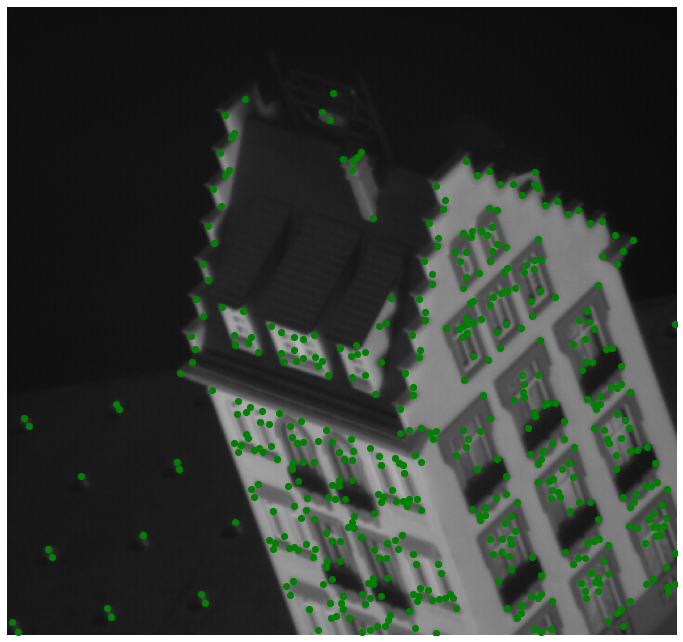

In [ ]:
import numpy as np
from scipy.ndimage.filters import convolve, gaussian_filter, maximum_filter
from scipy.ndimage.filters import generic_filter

def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold

  output: (N,2) array of [x,y] keypoints
  '''
  # Convert image to grayscale
  img_gray = np.mean(img, axis=2)

  # Apply Gaussian filter
  sigma = 1.5
  img_smooth = gaussian_filter(img_gray, sigma)

  # Compute Sobel operator for x and y gradients
  dx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  dy = dx.T
  Gx = convolve(img_smooth, dx)
  Gy = convolve(img_smooth, dy)

  # Compute second moment matrix components
  Ixx = Gx**2
  Ixy = Gx*Gy
  Iyy = Gy**2

  # Apply Gaussian filter to second moment matrix components
  Ixx_smooth = gaussian_filter(Ixx, sigma)
  Ixy_smooth = gaussian_filter(Ixy, sigma)
  Iyy_smooth = gaussian_filter(Iyy, sigma)

  # Compute Harris corner response
  det = Ixx_smooth * Iyy_smooth - Ixy_smooth**2
  trace = Ixx_smooth + Iyy_smooth
  R = det - tau * trace**2

  # Apply non-maximum suppression over 5x5 window
  window_size = 5
  R_max = maximum_filter(R, size=window_size, mode='constant')
  R_nms = R * (R == R_max)

  # Find pixels above threshold and are local maxima
  threshold = 0.001 * R_nms.max()
  local_maxima = generic_filter(R_nms, np.max, size=window_size) == R_nms
  keypoints = np.column_stack(np.where(np.logical_and(local_maxima, R_nms > threshold)))

  return keypoints

# compute keypoints in the first sequence
tau = 0.06
key_pts = getKeypoints(im[0], tau)

# add plots for the write-up
# YOUR CODE HERE
plt.figure(figsize=(12,12))
plt.imshow(im[0]/255.0, cmap='gray')
plt.scatter(key_pts[:,1], key_pts[:,0], s=10, color='g', linewidths=4)
plt.axis('off')
plt.show()


### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**1- Explain your implementation of getKeypoints():**

The function takes as input an image img and a threshold tau. It returns an (N,2) array of x,y keypoints that pass the Harris corner criterion. The function algorithm is as follows:

The input image is first converted to grayscale, then a Gaussian filter is applied to smooth the image. The Sobel operator is used to compute the x and y gradients of the smoothed image. The second moment matrix components (Ixx, Ixy, Iyy) are then computed from the gradients. Gaussian filtering is applied to the second moment matrix components to reduce noise. The Harris corner response R is computed from the second moment matrix components, and non-maximum suppression is applied over a 5x5 window to identify local maxima. Keypoints are then identified as pixels that are above a certain threshold and are local maxima.






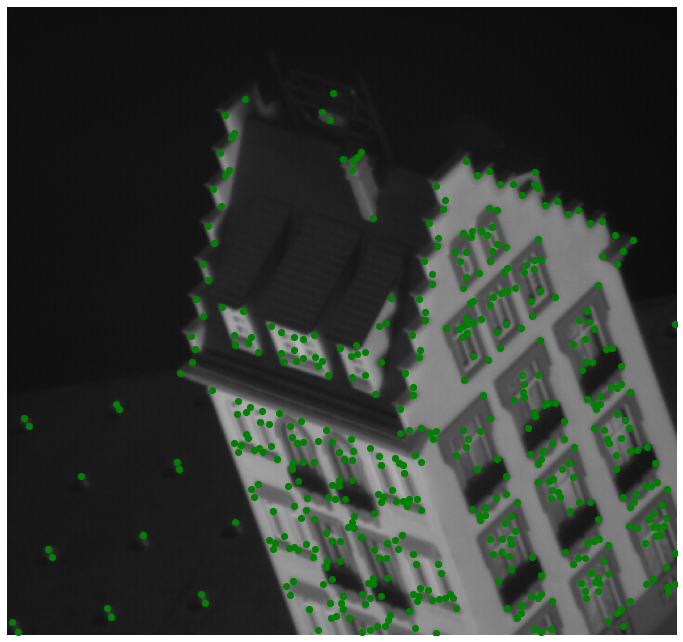

In [ ]:
#2) Display the first frame of the sequence overlaid with the detected keypoints.

plt.figure(figsize=(12,12))
plt.imshow(im[0]/255.0, cmap='gray')
plt.scatter(key_pts[:,1], key_pts[:,0], s=10, color='g', linewidths=4)
plt.axis('off')
plt.show()


## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence.

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/LK.jpeg" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section.



### Code (10 pts)


In [ ]:
# Helper Functions

from scipy import interpolate
from scipy.signal import convolve2d


def getPatch(im, x, y, ws):
    '''
    Extract patch of size (ws x ws) from the image centered around (x, y)
    '''
    patches = []
    for i in range(len(x)):
        patch = im[int(x[i])-ws//2:int(x[i])+ws//2+1, int(y[i])-ws//2:int(y[i])+ws//2+1]
        patches.append(patch)
    return np.array(patches)

<ipython-input-16-821d9643a703>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(patches)


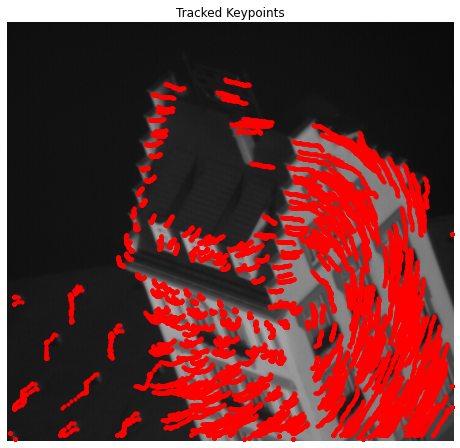

In [ ]:
import matplotlib.pyplot as plt

def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


  # Initialize the displacement vector
  u, v = 0, 0

  x_new = x+u
  y_new = y+v

  # Compute image gradients
  Ix_all = ndimage.sobel(im1, axis=0)
  Iy_all = ndimage.sobel(im1, axis=1)

  # Compute the template from im1 for the patch to be tracked
  template = getPatch(im1, x, y, ws)

  # Initialize iteration counter
  num_iterations = 0
  max_iterations = 100

  patch_im2 = np.zeros(template[0].shape)

  # Iterate until convergence
  while num_iterations < max_iterations:

    It_iter = []

    num_iterations += 1     # Increment iteration counter

    for i in range(len(x)):

      if template[i].shape != (ws,ws) or patch_im2.shape != (ws,ws):
        continue

      patch_im1 = im1[int(x[i])-ws//2:int(x[i])+ws//2+1, int(y[i])-ws//2:int(y[i])+ws//2+1]
      patch_im2 = im2[int(x_new[i])-ws//2:int(x_new[i])+ws//2+1, int(y_new[i])-ws//2:int(y_new[i])+ws//2+1]

      Ix = ndimage.sobel(patch_im1, axis=0)
      Iy = ndimage.sobel(patch_im1, axis=1)

      It = patch_im2 - patch_im1

      # Compute the sum square difference matrix
      A = np.array([[np.sum(Ix**2), np.sum(Ix*Iy)],
                    [np.sum(Ix*Iy), np.sum(Iy**2)]])
      b = np.array([-np.sum(Ix*It), -np.sum(Iy*It)])

      try:
        # Compute the displacement vector
        d = np.linalg.solve(A, b)
        u_new, v_new = d[0], d[1]
      except np.linalg.LinAlgError:
        # Singular matrix, stop iterating
        u_new, v_new = 0, 0


      # Shift the tracked keypoint positions
      x_new[i] = x_new[i] + u_new
      y_new[i] = y_new[i] + v_new

      patch_im2 = im2[int(x_new[i])-ws//2:int(x_new[i])+ws//2+1, int(y_new[i])-ws//2:int(y_new[i])+ws//2+1]


      if patch_im2.shape != (ws,ws):
        continue

      It_iter.append(patch_im2-patch_im1)

    # Stop iterating if the error vector is small enough
    if np.linalg.norm(np.array(It_iter)) < 0.01:
      break

  return x_new, y_new

# compute keypoints in the first and last sequences
tau = 0.06
key_pts_0 = getKeypoints(im[0], tau)
key_pts_50 = getKeypoints(im[-1], tau)

# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
track_x, track_y = trackPoints(key_pts_0[:,0], key_pts_0[:,1], im, ws=15)

# plot your results
# YOUR CODE HERE
# plot tracked keypoints overlayed on first sequence
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(im[0]/255.0)

# plot all tracked keypoints in red
ax.scatter(track_y, track_x, s=10, c='r')

ax.set_title('Tracked Keypoints')
plt.axis('off')
plt.show()



### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





**Include your write-up here**

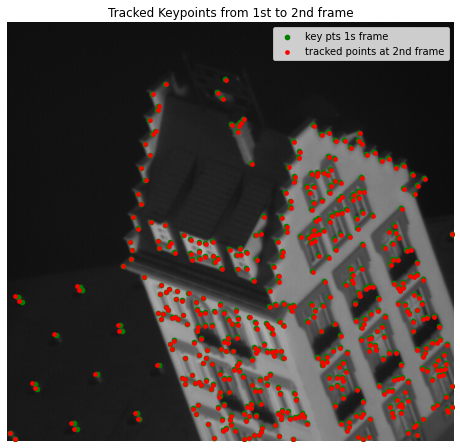

In [ ]:
'''
(5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
'''

# plot keypoints overlayed on first frame
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im[0]/255.0)
ax.scatter(key_pts_0[:,1], key_pts_0[:,0], s=7, c='g',linewidths=3,label='key pts 1s frame')
ax.scatter(track_y[:,1], track_x[:,1], s=3, c='r',linewidths=3, label='tracked points at 2nd frame')
ax.set_title('Tracked Keypoints from 1st to 2nd frame')
ax.legend()
plt.axis('off')
plt.show()


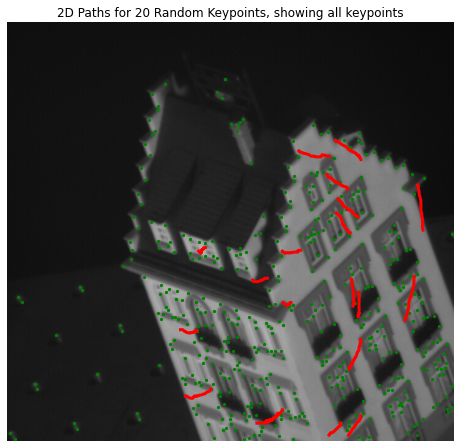

In [ ]:
'''(10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is,
 plot the progression of image coordinates for each of the 20 keypoints.
 Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
'''

import random

# plot tracked keypoints overlayed on first and last sequence
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im[0]/255.0)
ax.scatter(key_pts_0[:,1], key_pts_0[:,0], s=5, c='g')

# plot 2D paths for 20 random keypoints
random.seed(123)
random_indices = random.sample(range(track_x.shape[0]), 20)
for i, index in enumerate(random_indices):
    ax.plot(track_y[index], track_x[index], '-', color='r', linewidth=3)
ax.set_title('2D Paths for 20 Random Keypoints, showing all keypoints')
plt.axis('off')
plt.show()



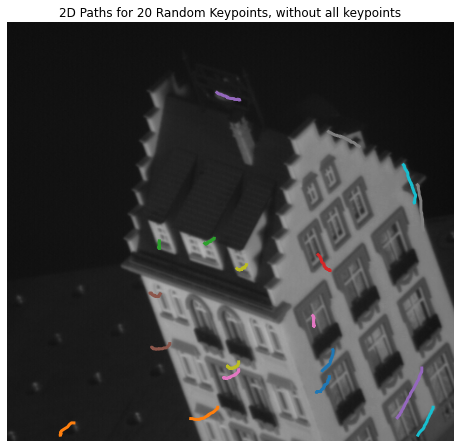

In [ ]:
# plot paths of 20 random keypoints on first frame

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im[0]/255.0)
for i in range(20):
    k = np.random.randint(len(key_pts_0))
    ax.plot(track_y[k,:], track_x[k,:], linewidth=3)
ax.set_title('2D Paths for 20 Random Keypoints, without all keypoints')
plt.axis('off')
plt.show()

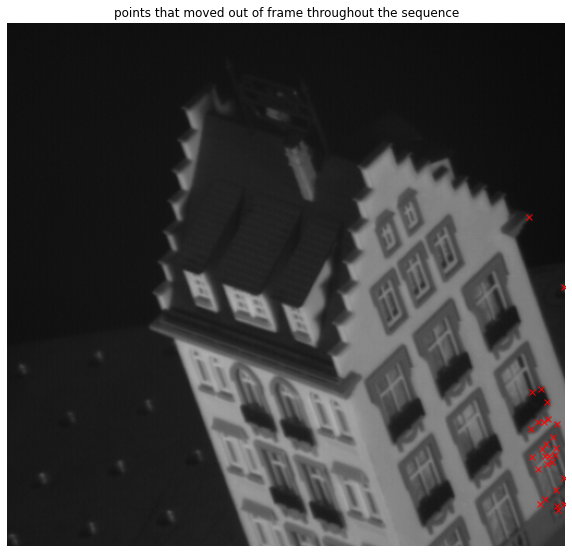

In [ ]:
# On top of the first frame, plot the points which have moved out of frame at some point along the sequence. (10 pts)

# plot the points that moved out of the frame on top of the first frame
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im[0]/255.0)
ax.set_title('points that moved out of frame throughout the sequence')

for i in range(len(key_pts_0)):
    if np.any(track_x[i,:] < 0) or np.any(track_x[i,:] >= im.shape[2]) or np.any(track_y[i,:] < 0) or np.any(track_y[i,:] >= im.shape[1]):
        ax.plot(key_pts_0[i,1], key_pts_0[i,0], 'rx')


plt.axis('off')
plt.show()